# Feedback-prop on multilabel model (COCO)

In [13]:
import argparse, os, string, pdb, time
from collections import defaultdict, OrderedDict
from tqdm import tqdm_notebook as tqdm

import numpy as np
from sklearn.metrics import average_precision_score

import torch
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torchvision.utils import save_image
from torch.utils.data import DataLoader

import data_loader
import model

import matplotlib.pyplot as plt
from IPython.core.display import display, HTML
%matplotlib inline
%load_ext autoreload
%autoreload 2

torch.manual_seed(1)
torch.cuda.manual_seed(1)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Create arguments for the script below

In [78]:
class Arguments:
    def __init__(self):
        self.annDir = 'COCO annotation path'
        self.imageDir = 'COCO image path'
        self.logDir = 'trained model path'

        self.imageSize = 256
        self.cropSize = 224
        self.batchSize = 64
        self.startEpoch = 1
        
args = Arguments()

### Define pre-processing

In [3]:
normMean = [0.49139968, 0.48215827, 0.44653124]
normStd = [0.24703233, 0.24348505, 0.26158768]
normTransform = transforms.Normalize(normMean, normStd)

testTransform = transforms.Compose([
    transforms.Resize(args.imageSize),
    transforms.CenterCrop(args.cropSize),
    transforms.ToTensor(),
    normTransform
])

### Load dataset.

In [5]:
valData = data_loader.loadValData(args, testTransform)
valLoader = DataLoader(valData, batch_size = 64, shuffle = False, pin_memory = False, num_workers = 10)

 
Loading val object annotations...

Preparing label space...
. . . . . . . . . . .


In [7]:
testData = data_loader.loadTestData(args, testTransform)
testLoader = DataLoader(testData, batch_size = 64, shuffle = False, pin_memory = False, num_workers = 10)


Loading test object annotations...

Preparing label space...
. . . . . . . . . . .


### Now let's divide the label space into "known" labels and "unknown" labels.
* We known the true values for the "known" labels.
* We don't know the true values for the "unknown" labels, these are the ones we are trying to predict.

In [9]:
def random_split_labelspace(data, numKnownLabels = 40):
    random_seq = np.random.permutation(data.numCategories())
    # We know the first K labels.
    knownLabels = [data.vocabulary[1].keys()[idx] for idx in random_seq[:numKnownLabels]]
    knownLabelIds = [data.word2id(word) for word in knownLabels]

    # We don't know the other labels.
    unknownLabels = [data.vocabulary[1].keys()[idx] for idx in random_seq[numKnownLabels:]]
    unknownLabelIds = [data.word2id(word) for word in unknownLabels]
    return knownLabels, knownLabelIds, unknownLabels, unknownLabelIds

label_space_split_file = 'coco_label_split500.p'

if not os.path.exists(label_space_split_file):
    knownLabels, knownLabelIds, unknownLabels, unknownLabelIds = random_split_labelspace(valData, 500)
    torch.save({'knownLabelIds': knownLabelIds, 'unknownLabelIds': unknownLabelIds,
                'knownLabels': knownLabels, 'unknownLabels': unknownLabels},
                open(label_space_split_file, 'w'))
else:
    space = torch.load(open(label_space_split_file))
    knownLabelIds = space['knownLabelIds']
    unknownLabelIds = space['unknownLabelIds']
    knownLabels = space['knownLabels']
    unknownLabels = space['unknownLabels']
# Show the two groups.
labelspace = ['<b>(%d)</b> [%s]' % (i + 1, label) for (i, label) in enumerate(knownLabels)]
labelspace = string.join(labelspace, '  ')
display(HTML('<h3>Known label-space</h3>'))
display(HTML(labelspace))

labelspace = ['<b>(%d)</b> [%s]' % (i + 1, label) for (i, label) in enumerate(unknownLabels)]
labelspace = string.join(labelspace, '  ')
display(HTML('<h3>Unknown label-space</h3>'))
display(HTML(labelspace))

## Layer-wise Feedback-prop

In [10]:
class LF(nn.Module):

    def __init__(self, n_categories):
        super(LF, self).__init__()
       
        self.n_categories = n_categories
        self.base_network = models.resnet18(pretrained = True)
        
        self.base_network.fc = nn.Conv2d(512, n_categories, 1)
        
        self.layers = [
            ('input_image', lambda x:x),
            ('conv1', lambda x: self.base_network.conv1(x)),
            ('conv5', lambda x: self.base_network.layer1(self.base_network.maxpool(
                self.base_network.relu(self.base_network.bn1(x))))),
            ('conv9',  lambda x: self.base_network.layer2(x)),
            ('conv13', lambda x: self.base_network.layer3(x)),
            ('conv17', lambda x: self.base_network.layer4(x)),
            ('fc', lambda x: self.base_network.fc(x)),
        ]

    def forward(self, x):
        for name, operator in self.layers:
            x = operator(x)
            setattr(self, name, x)
        # Take the max for each prediction map.
        return x.max(dim = 2, keepdim=True)[0].max(dim = 3, keepdim=True)[0].squeeze()
    
    def partial_forward(self, start):
        skip = True
        for name, operator in self.layers:
            if name == start:
                x = getattr(self, name)
                skip = False
            elif skip:
                continue
            else:
                x = operator(x)
                setattr(self, name, x)

        return x.max(dim = 2, keepdim=True)[0].max(dim = 3, keepdim=True)[0].squeeze()

In [11]:
# Prepare model.
LF_model = LF(1000)
LF_model = nn.DataParallel(LF_model).cuda()
checkpoint = torch.load(os.path.join(args.logDir, 'model_best.pth.tar'))
args.startEpoch = checkpoint['epoch']
best_error = checkpoint['error']
LF_model.load_state_dict(checkpoint['state_dict'])
print("=> loaded checkpoint (epoch {})".format(checkpoint['epoch']))

=> loaded checkpoint (epoch 41)


In [30]:
def feedback_prop_lf_val(net, knownLabelIds, unknownLabelIds, layers=['input_a'], num_iterations=20, lr=1e-3):
    net.eval()
    test_loss = 0
    correct = 0
    results = defaultdict(list)
    t = tqdm(valLoader, desc="Evaluating on Val:")
    t_knownLabelIds   = torch.LongTensor(knownLabelIds).cuda()
    t_unknownLabelIds = torch.LongTensor(unknownLabelIds).cuda()
    
    for batch_idx, (data, target, imageIds) in enumerate(t):
        # Prepare inputs.
#         if batch_idx == 10: break
        data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)

        # Inference.
        output = net(data)
        # Check the performance of known and unknown subsets
        knownLabelPredictions = output.index_select(1, Variable(t_knownLabelIds))
        knownLabelValues = target.index_select(1, Variable(t_knownLabelIds))
        unknownLabelPredictions = output.index_select(1, Variable(t_unknownLabelIds))
        unknownLabelValues = target.index_select(1, Variable(t_unknownLabelIds))
        
        for layer in layers:
            activation = Variable(getattr(net.module, layer).data, requires_grad=True)
            setattr(net.module, layer, activation)
            
            optimizer = optim.Adam([activation], lr = lr, weight_decay = 1e-4)
            for iteration in range(0, num_iterations):
                output = net.module.partial_forward(layer)
                knownLabelPredictions = output.index_select(1, Variable(t_knownLabelIds))
                loss = F.binary_cross_entropy_with_logits(knownLabelPredictions, knownLabelValues)
                optimizer.zero_grad()  
                loss.backward()
                optimizer.step()
                if layer == layers[-1]:
                    results[iteration].append((imageIds, output.data.cpu(), target.data.cpu()))
            output = net.module.partial_forward(layer)
            if layer == layers[-1]:
                results[iteration + 1].append((imageIds, output.data.cpu(), target.data.cpu()))
            activation.requires_grad = False  # Freeze this layer.

        # Logging information.
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += torch.gather(target.data, 1, pred).cpu().sum()
        t.set_postfix(correct = str(correct))
    
    predictions = dict()
    for iteration in results.keys():
        predictions[iteration] = torch.cat([entry[1] for entry in results[iteration]], 0)
    targets = torch.cat([entry[2] for entry in results[0]], 0)
    
    meanAP_unknown = list()
    meanAP_known = list()
    unknown_targets = targets.index_select(1, torch.LongTensor(unknownLabelIds)).numpy()
    known_targets = targets.index_select(1, torch.LongTensor(knownLabelIds)).numpy()
    for iteration in range(len(results)):
        meanAP_unknown.append(100 * ( average_precision_score(unknown_targets,
            (predictions[iteration] + 1e-5).index_select(1, torch.LongTensor(unknownLabelIds)).numpy(), average='macro')))
        meanAP_known.append(100 * ( average_precision_score(known_targets,
            (predictions[iteration] + 1e-5).index_select(1, torch.LongTensor(knownLabelIds)).numpy(), average='macro')))

    
    return meanAP_unknown, meanAP_known

In [42]:
meanAP_unknown, meanAP_known = feedback_prop_lf_val(
    LF_model, knownLabelIds, unknownLabelIds, layers=['conv13'], num_iterations=20, lr=3e-3)
print("number of iteration for max meanAP:", np.argmax(np.asarray(meanAP_unknown)))

('number of iteration for max meanAP:', 10)


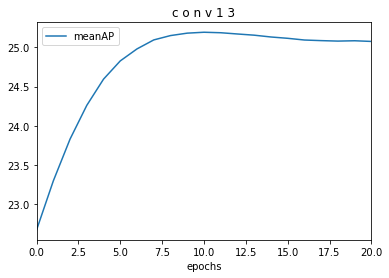

In [43]:
df = pd.DataFrame({'meanAP': meanAP_unknown}, index = range(0, 21))
df.index.name = "epochs"
plt.figure()
df.plot(title=' '.join('conv13'))

### Tune parameters(learning_rate and num_iterations) on val set and apply on test set

In [53]:
def feedback_prop_lf_test(net, knownLabelIds, unknownLabelIds, layers=['input_a'], num_iterations=20, lr=1e-3):
    net.eval()
    test_loss = 0
    correct = 0
    results = list()
    t = tqdm(testLoader, desc="Evaluating on Test:")
    t_knownLabelIds   = torch.LongTensor(knownLabelIds).cuda()
    t_unknownLabelIds = torch.LongTensor(unknownLabelIds).cuda()
    
    for batch_idx, (data, target, imageIds) in enumerate(t):
        # Prepare inputs.
#         if batch_idx == 3: break
        data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)

        # Inference.
        output = net(data)
        # Check the performance of known and unknown subsets
        knownLabelPredictions = output.index_select(1, Variable(t_knownLabelIds))
        knownLabelValues = target.index_select(1, Variable(t_knownLabelIds))
        unknownLabelPredictions = output.index_select(1, Variable(t_unknownLabelIds))
        unknownLabelValues = target.index_select(1, Variable(t_unknownLabelIds))
        
        for layer in layers:
            activation = Variable(getattr(net.module, layer).data, requires_grad=True)
            setattr(net.module, layer, activation)
            
            optimizer = optim.Adam([activation], lr = lr, weight_decay = 1e-4)
            for iteration in range(0, num_iterations):
                output = net.module.partial_forward(layer)
                knownLabelPredictions = output.index_select(1, Variable(t_knownLabelIds))
                loss = F.binary_cross_entropy_with_logits(knownLabelPredictions, knownLabelValues)
                optimizer.zero_grad()  
                loss.backward()
                optimizer.step()
            output = net.module.partial_forward(layer)
            activation.requires_grad = False  # Freeze this layer.

        # Logging information.
        results.append((imageIds, output.data.cpu(), target.data.cpu(), unknownLabelPredictions.data.cpu()))
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += torch.gather(target.data, 1, pred).cpu().sum()
        t.set_postfix(correct = str(correct))
    
    predictions = torch.cat([entry[1] for entry in results], 0)
    targets = torch.cat([entry[2] for entry in results], 0)
    ori_predictions = torch.cat([entry[3] for entry in results], 0)
    old_meanAP = 100 * (average_precision_score(targets.index_select(1, torch.LongTensor(unknownLabelIds)).numpy(),
                                     (ori_predictions + 1e-5).numpy(),
                                    average = 'macro'))
    new_meanAP = 100 * (average_precision_score(targets.index_select(1, torch.LongTensor(unknownLabelIds)).numpy(),
                                     (predictions + 1e-5).index_select(1, torch.LongTensor(unknownLabelIds)).numpy(),
                                    average = 'macro'))
    
    return old_meanAP, new_meanAP

#### Note that once ***unknown set*** and ***known set*** are regenerated, meanAP score could be different from the numbers reported in the paper.

In [57]:
mAP_base, mAP_lf = feedback_prop_lf_test(LF_model, knownLabelIds, unknownLabelIds, layers=['conv13'], num_iterations=10, lr=3e-3)
print('meanAP of test split without feedback-prop: {}\nmeanAP of test split with layer-wise feedback-prop: {}'.format(mAP_base, mAP_lf))

meanAP of test split without feedback-prop: 22.9942420978
meanAP of test split with layer-wise feedback-prop: 25.2597447873


## Residual Feedback-prop

In [62]:
class RF(nn.Module):

    def __init__(self, n_categories):
        super(RF, self).__init__()
       
        self.n_categories = n_categories
        self.base_network = models.resnet18(pretrained = True)
        
        self.base_network.fc = nn.Conv2d(512, n_categories, 1)
        
        self.layers = [
            ('input_image', lambda x:x),
            ('conv1', lambda x: self.base_network.conv1(x)),
            ('conv5', lambda x: self.base_network.layer1(self.base_network.maxpool(
                self.base_network.relu(self.base_network.bn1(x))))),
            ('conv9',  lambda x: self.base_network.layer2(x)),
            ('conv13', lambda x: self.base_network.layer3(x)),
            ('conv17', lambda x: self.base_network.layer4(x)),
            ('fc', lambda x: self.base_network.fc(x)),
        ]

    def forward(self, x, aux={}):
        for name, operator in self.layers:
            x = operator(x)
            if name in aux:
                x = x + aux[name]
            setattr(self, name, x)
        # Take the max for each prediction map.
        return x.max(dim = 2, keepdim=True)[0].max(dim = 3, keepdim=True)[0].squeeze()
    
    def partial_forward(self, start, aux={}):
        skip = True
        for name, operator in self.layers:
            if name == start:
                x = getattr(self, name)
                x = x + aux[name]
                skip = False
            elif skip:
                continue
            else:
                x = operator(x)
                if name in aux:
                    x = x + aux[name]
                    
        return x.max(dim = 2, keepdim=True)[0].max(dim = 3, keepdim=True)[0].squeeze()

In [63]:
# Prepare model.
RF_model = RF(1000)
RF_model = nn.DataParallel(RF_model).cuda()
checkpoint = torch.load(os.path.join(args.logDir, 'model_best.pth.tar'))
args.startEpoch = checkpoint['epoch']
best_error = checkpoint['error']
RF_model.load_state_dict(checkpoint['state_dict'])
print("=> loaded checkpoint (epoch {})".format(checkpoint['epoch']))

=> loaded checkpoint (epoch 41)


In [66]:
def feedback_prop_rf_val(net,knownLabelIds, unknownLabelIds, layers=['input_a'], num_iterations=20, lr=1e-3):
    net.eval()
    test_loss = 0
    correct = 0
    results = defaultdict(list)
    t = tqdm(testLoader, desc="Evaluating on Val:")
    t_knownLabelIds   = torch.LongTensor(knownLabelIds).cuda()
    t_unknownLabelIds = torch.LongTensor(unknownLabelIds).cuda()
    
    for batch_idx, (data, target, imageIds) in enumerate(t):
        # Prepare inputs.
#         if batch_idx == 10: break
        data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)

        # Inference.
        output = net(data)
        # Check the unobserved loss.
        knownLabelPredictions = output.index_select(1, Variable(t_knownLabelIds))
        knownLabelValues = target.index_select(1, Variable(t_knownLabelIds))
        unknownLabelPredictions = output.index_select(1, Variable(t_unknownLabelIds))
        unknownLabelValues = target.index_select(1, Variable(t_unknownLabelIds))
        
        aux = {}
        for layer in layers:
            aux_activation = torch.FloatTensor(getattr(net.module, layer).data.size()).zero_().cuda()
            aux[layer] = Variable(aux_activation, requires_grad=True)
        
        activation = Variable(getattr(net.module, layers[0]).data, requires_grad=True)
        setattr(net.module, layers[0], activation)
            
        optimizer = optim.Adam([aux[name] for name in aux], lr = lr, weight_decay = 1e-4)
        for iteration in range(0, num_iterations):
            output = net.module.partial_forward(layers[0], aux=aux)
            knownLabelPredictions = output.index_select(1, Variable(t_knownLabelIds))
            loss = F.binary_cross_entropy_with_logits(knownLabelPredictions, knownLabelValues)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            results[iteration].append((imageIds, output.data.cpu(), target.data.cpu()))
        output = net.module.partial_forward(layers[0], aux=aux)
        results[iteration + 1].append((imageIds, output.data.cpu(), target.data.cpu()))

        # Logging information.
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += torch.gather(target.data, 1, pred).cpu().sum()
        t.set_postfix(correct = str(correct))
    
    predictions = dict()
    for iteration in results.keys():
        predictions[iteration] = torch.cat([entry[1] for entry in results[iteration]], 0)
    targets = torch.cat([entry[2] for entry in results[0]], 0)
    
    meanAP_unknown = list()
    meanAP_known = list()
    unknown_targets = targets.index_select(1, torch.LongTensor(unknownLabelIds)).numpy()
    known_targets = targets.index_select(1, torch.LongTensor(knownLabelIds)).numpy()
    for iteration in range(len(results)):
        meanAP_unknown.append(100 * ( average_precision_score(unknown_targets,
            (predictions[iteration] + 1e-5).index_select(1, torch.LongTensor(unknownLabelIds)).numpy(), average='macro')))
        meanAP_known.append(100 * ( average_precision_score(known_targets,
            (predictions[iteration] + 1e-5).index_select(1, torch.LongTensor(knownLabelIds)).numpy(), average='macro')))

    
    return meanAP_unknown, meanAP_known

In [67]:
meanAP_unknown, meanAP_known = feedback_prop_rf_val(
    RF_model, knownLabelIds, unknownLabelIds, layers=['conv13'], num_iterations=20, lr=3e-3)
print("number of iteration for max meanAP:", np.argmax(np.asarray(meanAP_unknown)))

('number of iteration for max meanAP:', 10)


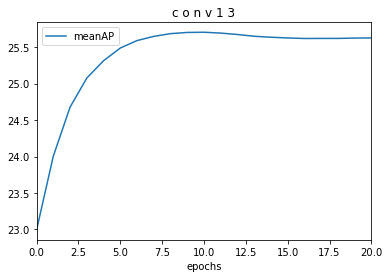

In [68]:
df = pd.DataFrame({'meanAP': meanAP_unknown}, index = range(0, 21))
df.index.name = "epochs"
plt.figure()
df.plot(title=' '.join('conv13'))

### Tune parameters(learning_rate and num_iterations) on val set and apply on test set

In [76]:
def feedback_prop_rf_test(net, knownLabelIds, unknownLabelIds, layers=['input_a'], num_iterations=20, lr=1e-3):
    net.eval()
    test_loss = 0
    correct = 0
    results = list()
    t = tqdm(testLoader, desc="Evaluating on Test:")
    t_knownLabelIds   = torch.LongTensor(knownLabelIds).cuda()
    t_unknownLabelIds = torch.LongTensor(unknownLabelIds).cuda()
    
    for batch_idx, (data, target, imageIds) in enumerate(t):
        # Prepare inputs.
#         if batch_idx == 3: break
        data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)

        # Inference.
        output = net(data)
        # Check the unobserved loss.
        knownLabelPredictions = output.index_select(1, Variable(t_knownLabelIds))
        knownLabelValues = target.index_select(1, Variable(t_knownLabelIds))
        unknownLabelPredictions = output.index_select(1, Variable(t_unknownLabelIds))
        unknownLabelValues = target.index_select(1, Variable(t_unknownLabelIds))
        
        aux = {}
        for layer in layers:
            aux_activation = torch.FloatTensor(getattr(net.module, layer).data.size()).zero_().cuda()
            aux[layer] = Variable(aux_activation, requires_grad=True)
        
        activation = Variable(getattr(net.module, layers[0]).data, requires_grad=True)
        setattr(net.module, layers[0], activation)
            
        optimizer = optim.Adam([aux[name] for name in aux], lr = lr, weight_decay = 1e-4)
        for iteration in range(0, num_iterations + 1):
            output = net.module.partial_forward(layers[0], aux=aux)
            knownLabelPredictions = output.index_select(1, Variable(t_knownLabelIds))
            loss = F.binary_cross_entropy_with_logits(knownLabelPredictions, knownLabelValues)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        output = net.module.partial_forward(layers[0], aux=aux)

        # Logging information.
        results.append((imageIds, output.data.cpu(), target.data.cpu(), unknownLabelPredictions.data.cpu()))
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += torch.gather(target.data, 1, pred).cpu().sum()
        t.set_postfix(correct = str(correct))
    
    predictions = torch.cat([entry[1] for entry in results], 0)
    targets = torch.cat([entry[2] for entry in results], 0)
    ori_predictions = torch.cat([entry[3] for entry in results], 0)
    old_meanAP = 100 * (average_precision_score(targets.index_select(1, torch.LongTensor(unknownLabelIds)).numpy(),
                                     (ori_predictions + 1e-5).numpy(),
                                    average = 'macro'))
    new_meanAP = 100 * (average_precision_score(targets.index_select(1, torch.LongTensor(unknownLabelIds)).numpy(),
                                     (predictions + 1e-5).index_select(1, torch.LongTensor(unknownLabelIds)).numpy(),
                                    average = 'macro'))
    
    return old_meanAP, new_meanAP

In [77]:
mAP_base, mAP_rf = feedback_prop_rf_test(RF_model, knownLabelIds, unknownLabelIds, layers=['conv13'], num_iterations=10, lr=3e-3)
print('meanAP of test split without feedback-prop: {}\nmeanAP of test split with residual feedback-prop: {}'.format(mAP_base, mAP_rf))

meanAP of test split without feedback-prop: 22.9942420978
meanAP of test split with residual feedback-prop: 25.6912361887
